In [1]:
#@title Data retrieval
import os, requests

fname = "stringer_orientations.npy"
url = "https://osf.io/ny4ut/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [2]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
#@title Data loading
import numpy as np
dat = np.load('stringer_orientations.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes', 'run', 'info', 'xyz'])


In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/'My Drive'/Research/NMA/stringer-et-al-2019-master
from decoders import *
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Research/NMA/stringer-et-al-2019-master


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.manifold.isomap module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
#pruning so it's divisible by 4 so that...
X = dat['sresp'].T[:-2,:]
y = dat['istim'][:-2]

num_dims = 2**np.arange(2,10)
num_trials = len(dat['istim'])
#...we can create the data structures for storing the predicted angles and error for each fold easily
apred = np.zeros((len(num_dims),num_trials//4,4))
error = np.zeros((len(num_dims),num_trials//4,4))

kf = KFold(n_splits=4)

In [6]:
for i, k in enumerate(num_dims):
    print('Training on',k,'dimensions')
    transformer = PCA(n_components=k, random_state=0)
    X_fa = transformer.fit_transform(X)
    print('PCA complete')
    for j, indices in enumerate(kf.split(X_fa)):
        print('Split #',j+1)
        train_index = indices[0]
        test_index = indices[1]
        d = vonmises_decoder(X_fa.T, y, train_index, test_index)

        apred[i,:,j] = d[0]
        error[i,:,j] = d[1]

Training on 4 dimensions
Factor analysis complete
Split # 1
Split # 2
Split # 3
Split # 4
Training on 8 dimensions
Factor analysis complete
Split # 1
Split # 2
Split # 3
Split # 4
Training on 16 dimensions
Factor analysis complete
Split # 1
Split # 2
Split # 3
Split # 4
Training on 32 dimensions
Factor analysis complete
Split # 1
Split # 2
Split # 3
Split # 4
Training on 64 dimensions
Factor analysis complete
Split # 1
Split # 2
Split # 3
Split # 4
Training on 128 dimensions
Factor analysis complete
Split # 1
Split # 2
Split # 3
Split # 4
Training on 256 dimensions
Factor analysis complete
Split # 1
Split # 2
Split # 3
Split # 4
Training on 512 dimensions
Factor analysis complete
Split # 1
Split # 2
Split # 3
Split # 4


Text(0, 0.5, 'Median decoding error (degrees)')

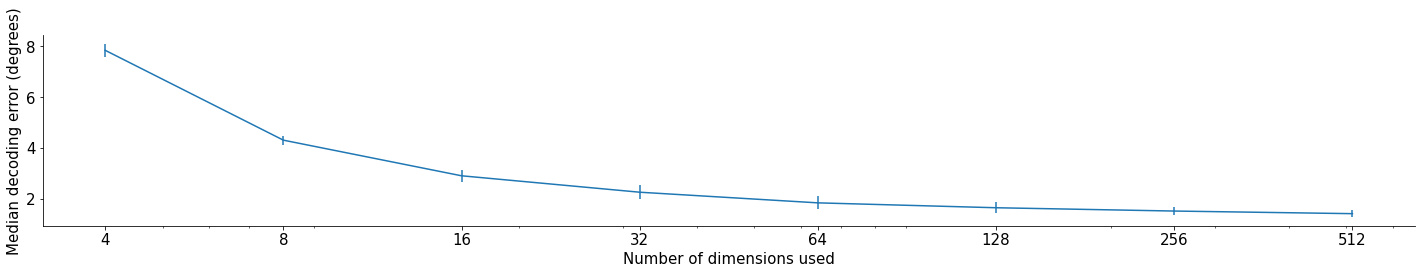

In [7]:
med_error = np.median(np.abs(error),axis=(1,2))
se = np.std(np.median(error,axis=1),axis=1)/ 2 # sqrt of 4 samples is 2

plt.errorbar(num_dims,med_error*180/np.pi,yerr=se*180/np.pi)

ax = plt.gca()
ax.set_xscale('log')
plt.xticks(num_dims,num_dims)
plt.xlabel('Number of dimensions used')
plt.ylabel('Median decoding error (degrees)')

In [8]:
np.save('../pca_apred.npy',apred)
np.save('../pca_error.npy',error)